## This is the svm workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a linear support vector machine.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and includes code to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training an SVM classifier via gradient descent.

## Importing libraries and data setup

In [2]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from cs231n.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.
import pdb

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Set the path to the CIFAR-10 data
cifar10_dir = '/Users/victoryang/ece247/HW2/HW2-code/nndl/cifar-10-batches-py' # You need to update this line
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


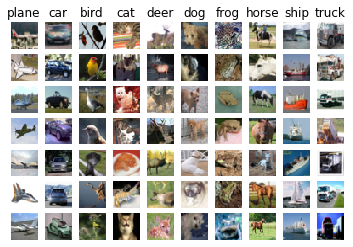

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Dev data shape:  (500, 32, 32, 3)
Dev labels shape:  (500,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


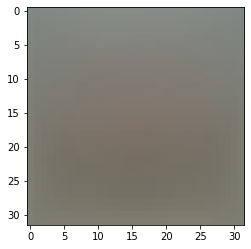

In [7]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [8]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Question:

(1) For the SVM, we perform mean-subtraction on the data.
However, for the KNN notebook, we did not.
Why?

## Answer:

(1) Since KNN does not have gradient decent algorithm, we did not perform mean-subtraction on the data. The reason why we perform mean-subtraction in SVM is that weight gradients(some extreme cases) may cause gradient equal to zero or infinity. 

## Training an SVM

The following cells will take you through building an SVM.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [10]:
from nndl.svm import SVM

In [11]:
# Declare an instance of the SVM class.  
# Weights are initialized to a random value.
# Note, to keep people's initial solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

svm = SVM(dims=[num_classes, num_features])

#### SVM loss

In [12]:
## Implement the loss function for in the SVM class(nndl/svm.py), svm.loss()

loss = svm.loss(X_train, y_train)
print('The training set loss is {}.'.format(loss))

# If you implemented the loss correctly, it should be 15569.98

The training set loss is 15569.977915410193.


#### SVM gradient

In [13]:
## Calculate the gradient of the SVM class.
# For convenience, we'll write one function that computes the loss
#   and gradient together. Please modify svm.loss_and_grad(X, y).
# You may copy and paste your loss code from svm.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = svm.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a numerical gradient check. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
svm.grad_check_sparse(X_dev, y_dev, grad)

numerical: -7.651109 analytic: -7.651109, relative error: 1.714372e-08
numerical: 5.913614 analytic: 5.913614, relative error: 3.609035e-08
numerical: -2.680651 analytic: -2.680651, relative error: 1.214167e-07
numerical: 13.576894 analytic: 13.576894, relative error: 8.598508e-09
numerical: 4.573681 analytic: 4.573680, relative error: 1.088658e-08
numerical: 2.688693 analytic: 2.688693, relative error: 2.649134e-09
numerical: 10.191364 analytic: 10.191364, relative error: 7.991695e-09
numerical: -10.217350 analytic: -10.217351, relative error: 3.592322e-08
numerical: -10.518884 analytic: -10.518884, relative error: 7.758800e-09
numerical: -22.198153 analytic: -22.198153, relative error: 7.816928e-09


## A vectorized version of SVM

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [14]:
import time

In [15]:
## Implement svm.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = svm.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = svm.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} / {}'.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output, i.e., differences on the order of 1e-12

Normal loss / grad_norm: 15939.137429114282 / 2230.820945748348 computed in 0.030182838439941406s
Vectorized loss / grad: 15939.137429114317 / 2230.820945748348 computed in 0.0030798912048339844s
difference in loss / grad: -3.456079866737127e-11 / 7.631442049656887e-12


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 16557.380001909158
iteration 100 / 1500: loss 4701.089451272714
iteration 200 / 1500: loss 4017.333137942788
iteration 300 / 1500: loss 3681.9226471953625
iteration 400 / 1500: loss 2732.6164373988995
iteration 500 / 1500: loss 2786.6378424645054
iteration 600 / 1500: loss 2837.035784278267
iteration 700 / 1500: loss 2206.2348687399326
iteration 800 / 1500: loss 2269.03882411698
iteration 900 / 1500: loss 2543.23781538592
iteration 1000 / 1500: loss 2566.6921357268266
iteration 1100 / 1500: loss 2182.068905905164
iteration 1200 / 1500: loss 1861.118224425045
iteration 1300 / 1500: loss 1982.9013858528258
iteration 1400 / 1500: loss 1927.5204158582114
That took 5.619168043136597s


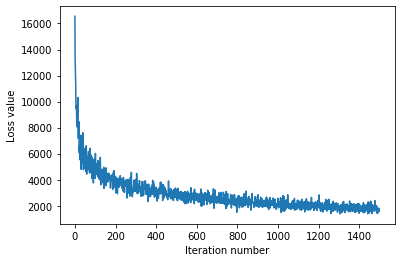

In [16]:
# Implement svm.train() by filling in the code to extract a batch of data
# and perform the gradient step.

tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=5e-4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained SVM on the validation data.

In [17]:
## Implement svm.predict() and use it to compute the training and testing error.

y_train_pred = svm.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = svm.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.28530612244897957
validation accuracy: 0.3


## Optimize the SVM

Note, to make things faster and simpler, we won't do k-fold cross-validation, but will only optimize the hyperparameters on the validation dataset (X_val, y_val).

Learning_rate is: 0.0002
iteration 0 / 1500: loss 17772.834341836522
iteration 100 / 1500: loss 5963.521397699751
iteration 200 / 1500: loss 4817.035094768841
iteration 300 / 1500: loss 4101.183613999858
iteration 400 / 1500: loss 3745.7208397270424
iteration 500 / 1500: loss 3357.2783762644663
iteration 600 / 1500: loss 3321.618657981088
iteration 700 / 1500: loss 3595.1569870765998
iteration 800 / 1500: loss 2943.041276519569
iteration 900 / 1500: loss 3418.2429853290973
iteration 1000 / 1500: loss 2931.602676394687
iteration 1100 / 1500: loss 2652.6534108281594
iteration 1200 / 1500: loss 2641.047336080247
iteration 1300 / 1500: loss 2936.5782706460636
iteration 1400 / 1500: loss 2391.1566900618486


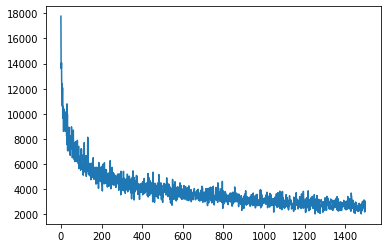

Learning_rate is: 0.0003
iteration 0 / 1500: loss 23298.531266498594
iteration 100 / 1500: loss 4902.196787133855
iteration 200 / 1500: loss 5086.386457019775
iteration 300 / 1500: loss 3982.894395463705
iteration 400 / 1500: loss 3075.60507175878
iteration 500 / 1500: loss 3424.3253961847245
iteration 600 / 1500: loss 3644.190815585723
iteration 700 / 1500: loss 2923.5484435432286
iteration 800 / 1500: loss 2340.526526030581
iteration 900 / 1500: loss 2460.561626235428
iteration 1000 / 1500: loss 2470.7549491880695
iteration 1100 / 1500: loss 2796.391478599336
iteration 1200 / 1500: loss 2381.836065788721
iteration 1300 / 1500: loss 2837.766143705449
iteration 1400 / 1500: loss 2002.4192134903099


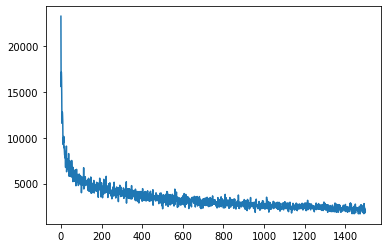

Learning_rate is: 0.0004
iteration 0 / 1500: loss 17434.679795253487
iteration 100 / 1500: loss 5107.921055895462
iteration 200 / 1500: loss 4451.490686188232
iteration 300 / 1500: loss 3554.5829049639065
iteration 400 / 1500: loss 3913.371349108427
iteration 500 / 1500: loss 2985.5193822577817
iteration 600 / 1500: loss 2501.6357260005584
iteration 700 / 1500: loss 2693.2693992026593
iteration 800 / 1500: loss 2609.808119516772
iteration 900 / 1500: loss 2600.7288025569183
iteration 1000 / 1500: loss 2432.4352818696034
iteration 1100 / 1500: loss 2076.939565756936
iteration 1200 / 1500: loss 2007.603203284592
iteration 1300 / 1500: loss 2236.436248093082
iteration 1400 / 1500: loss 2227.8636427449646


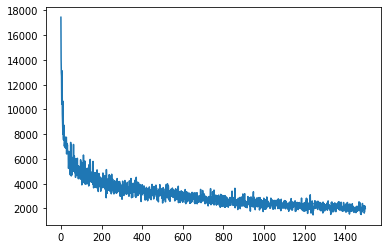

Learning_rate is: 0.0005
iteration 0 / 1500: loss 17726.97708162432
iteration 100 / 1500: loss 4622.555946884402
iteration 200 / 1500: loss 3788.9047560603303
iteration 300 / 1500: loss 3509.006086942091
iteration 400 / 1500: loss 2733.545841438216
iteration 500 / 1500: loss 2787.7145441632897
iteration 600 / 1500: loss 3454.4515876714777
iteration 700 / 1500: loss 2781.9853363182874
iteration 800 / 1500: loss 2730.237871184907
iteration 900 / 1500: loss 2498.210205141136
iteration 1000 / 1500: loss 2331.5832178335872
iteration 1100 / 1500: loss 2005.4376827706021
iteration 1200 / 1500: loss 1956.5878885315406
iteration 1300 / 1500: loss 1387.7504523248292
iteration 1400 / 1500: loss 2238.7081319118997


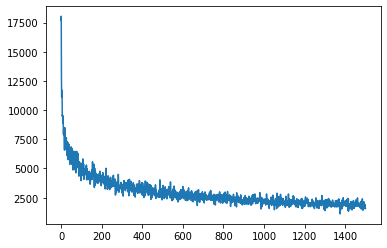

Learning_rate is: 0.0006
iteration 0 / 1500: loss 17439.114360917345
iteration 100 / 1500: loss 4437.681497994294
iteration 200 / 1500: loss 3510.862735970908
iteration 300 / 1500: loss 3409.768879377936
iteration 400 / 1500: loss 2620.4678942833057
iteration 500 / 1500: loss 3415.6209773172636
iteration 600 / 1500: loss 1813.3825774302202
iteration 700 / 1500: loss 2225.5298964493063
iteration 800 / 1500: loss 2060.6516138346724
iteration 900 / 1500: loss 2206.9053369444646
iteration 1000 / 1500: loss 1978.1639698298573
iteration 1100 / 1500: loss 1809.777803680909
iteration 1200 / 1500: loss 1920.0247822821295
iteration 1300 / 1500: loss 2118.8491229052515
iteration 1400 / 1500: loss 1983.1084398952732


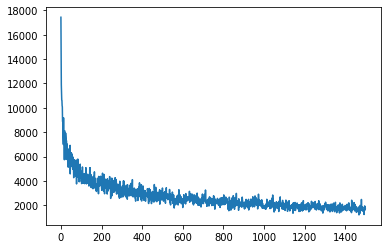

Learning_rate is: 0.002
iteration 0 / 1500: loss 15370.641063153469
iteration 100 / 1500: loss 4228.172288765517
iteration 200 / 1500: loss 6367.436066532225
iteration 300 / 1500: loss 3229.294390191041
iteration 400 / 1500: loss 2930.849718539847
iteration 500 / 1500: loss 3197.0776265506006
iteration 600 / 1500: loss 2586.445448035455
iteration 700 / 1500: loss 3189.519802940945
iteration 800 / 1500: loss 4742.3380628942605
iteration 900 / 1500: loss 3524.3290912128014
iteration 1000 / 1500: loss 2415.8330050081786
iteration 1100 / 1500: loss 2708.665009558004
iteration 1200 / 1500: loss 2699.3960616283457
iteration 1300 / 1500: loss 3428.6002243907906
iteration 1400 / 1500: loss 2535.993575588802


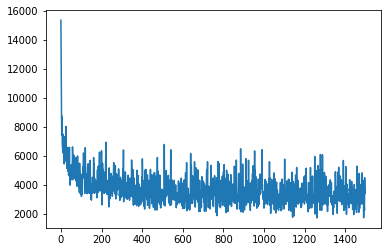

Learning_rate is: 0.003
iteration 0 / 1500: loss 17834.89814950957
iteration 100 / 1500: loss 4289.780209299642
iteration 200 / 1500: loss 6001.153515161723
iteration 300 / 1500: loss 5259.448580517055
iteration 400 / 1500: loss 4341.309565769409
iteration 500 / 1500: loss 3617.0715774162773
iteration 600 / 1500: loss 5586.685444030273
iteration 700 / 1500: loss 7482.243928599777
iteration 800 / 1500: loss 5914.544097296321
iteration 900 / 1500: loss 7269.216022041176
iteration 1000 / 1500: loss 5937.95973474574
iteration 1100 / 1500: loss 3863.4935098947926
iteration 1200 / 1500: loss 3684.325139830406
iteration 1300 / 1500: loss 5581.7935817031
iteration 1400 / 1500: loss 3462.5837423416383


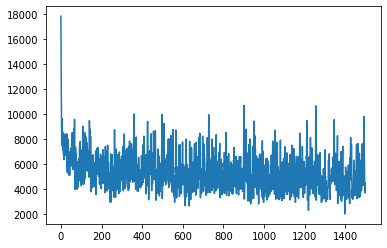

Learning_rate is: 0.004
iteration 0 / 1500: loss 15754.992051210502
iteration 100 / 1500: loss 4693.222824717798
iteration 200 / 1500: loss 5617.248167988691
iteration 300 / 1500: loss 4339.159796756382
iteration 400 / 1500: loss 5543.71204321261
iteration 500 / 1500: loss 5677.387178363665
iteration 600 / 1500: loss 5189.879938138504
iteration 700 / 1500: loss 5888.598072365696
iteration 800 / 1500: loss 9955.318631268448
iteration 900 / 1500: loss 4553.1248443813565
iteration 1000 / 1500: loss 4488.468676737892
iteration 1100 / 1500: loss 6003.770385259425
iteration 1200 / 1500: loss 11489.125855871145
iteration 1300 / 1500: loss 3011.9949727715207
iteration 1400 / 1500: loss 8400.74001378917


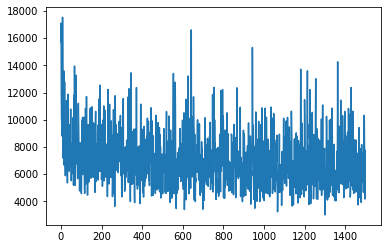

Learning_rate is: 0.005
iteration 0 / 1500: loss 17524.021088432826
iteration 100 / 1500: loss 11075.196524059274
iteration 200 / 1500: loss 11895.076850498222
iteration 300 / 1500: loss 7531.999081235181
iteration 400 / 1500: loss 6532.010303069979
iteration 500 / 1500: loss 8197.539422804795
iteration 600 / 1500: loss 5686.98847409257
iteration 700 / 1500: loss 11243.808849055958
iteration 800 / 1500: loss 11395.759698896876
iteration 900 / 1500: loss 6900.513196605158
iteration 1000 / 1500: loss 14411.242201323379
iteration 1100 / 1500: loss 6888.372105526593
iteration 1200 / 1500: loss 6266.744308036672
iteration 1300 / 1500: loss 6789.766496154144
iteration 1400 / 1500: loss 7330.936525646879


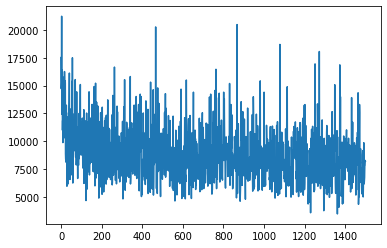

Learning_rate is: 0.006
iteration 0 / 1500: loss 16632.954615132494
iteration 100 / 1500: loss 9444.93813584483
iteration 200 / 1500: loss 27972.40990745096
iteration 300 / 1500: loss 6790.46627531847
iteration 400 / 1500: loss 5484.306450914496
iteration 500 / 1500: loss 7904.015168273148
iteration 600 / 1500: loss 10163.910686396073
iteration 700 / 1500: loss 6547.064277913272
iteration 800 / 1500: loss 8520.601971104717
iteration 900 / 1500: loss 11013.207312157636
iteration 1000 / 1500: loss 8765.236704924346
iteration 1100 / 1500: loss 9464.535412820662
iteration 1200 / 1500: loss 7971.093399660389
iteration 1300 / 1500: loss 9571.394907924858
iteration 1400 / 1500: loss 13582.278389047067


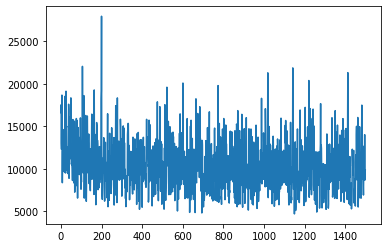

Learning_rate is: 0.04
iteration 0 / 1500: loss 18951.596177882006
iteration 100 / 1500: loss 81396.74496501226
iteration 200 / 1500: loss 88701.97877811686
iteration 300 / 1500: loss 66535.09529249635
iteration 400 / 1500: loss 116017.97360913384
iteration 500 / 1500: loss 55832.529770331814
iteration 600 / 1500: loss 61164.072645394896
iteration 700 / 1500: loss 57105.53608419883
iteration 800 / 1500: loss 61680.346634654736
iteration 900 / 1500: loss 50880.52021370914
iteration 1000 / 1500: loss 73174.48320512146
iteration 1100 / 1500: loss 60281.96386337841
iteration 1200 / 1500: loss 75632.17088705882
iteration 1300 / 1500: loss 65215.22808284845
iteration 1400 / 1500: loss 77434.7398459093


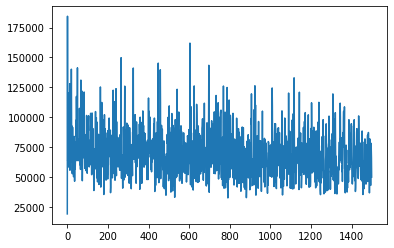

Learning_rate is: 0.05
iteration 0 / 1500: loss 15217.150990962667
iteration 100 / 1500: loss 85772.80970704355
iteration 200 / 1500: loss 110967.2046710641
iteration 300 / 1500: loss 115202.18988940581
iteration 400 / 1500: loss 90446.4375466618
iteration 500 / 1500: loss 65957.80823484731
iteration 600 / 1500: loss 102219.51709678411
iteration 700 / 1500: loss 83849.02544525696
iteration 800 / 1500: loss 78820.30853883017
iteration 900 / 1500: loss 118564.51433740456
iteration 1000 / 1500: loss 37475.72000284748
iteration 1100 / 1500: loss 65693.59901128277
iteration 1200 / 1500: loss 105561.06543762657
iteration 1300 / 1500: loss 131582.19896679514
iteration 1400 / 1500: loss 125313.4832639005


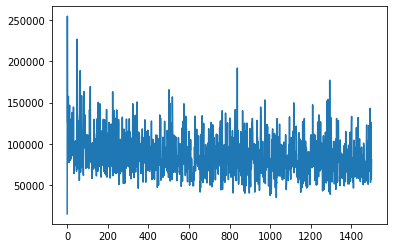

Learning_rate is: 0.06
iteration 0 / 1500: loss 13899.349003082632
iteration 100 / 1500: loss 110470.05131352998
iteration 200 / 1500: loss 73929.01013567307
iteration 300 / 1500: loss 122991.37202856323
iteration 400 / 1500: loss 106620.79504080198
iteration 500 / 1500: loss 75860.68823755761
iteration 600 / 1500: loss 115033.34196014734
iteration 700 / 1500: loss 115965.57646533202
iteration 800 / 1500: loss 101768.29779480144
iteration 900 / 1500: loss 71545.97543339808
iteration 1000 / 1500: loss 104204.67981796326
iteration 1100 / 1500: loss 151381.54832272034
iteration 1200 / 1500: loss 116730.97887226444
iteration 1300 / 1500: loss 103120.69719482407
iteration 1400 / 1500: loss 133719.2319328738


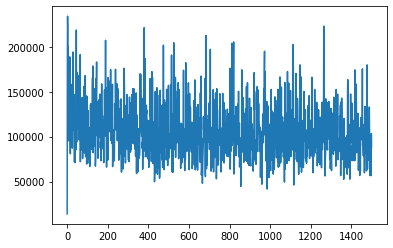

The best learning rate is: 0.000600
The highest accuracy is: 0.338000


In [18]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the SVM with different learning rates and evaluate on the
#     validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best VALIDATION accuracy corresponding to the best VALIDATION error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
#   Note: You do not need to modify SVM class for this section
# ================================================================ #
learning_rates = [4e-2, 5e-2, 6e-2, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4]
learning_rates_sort = np.sort(learning_rates)
accuracy = []

for lr in learning_rates_sort:
    print('Learning_rate is:', lr)
    loss_best_lr = svm.train(X_train, y_train, learning_rate = lr,
                      num_iters=1500, verbose=True)
    plt.plot(loss_best_lr)
    plt.show()
    y_pred_best_lr = svm.predict(X_val)
    accuracy.append(np.mean(np.equal(y_val, y_pred_best_lr)),)

print('The best learning rate is: %f' %learning_rates[np.argmax(accuracy)])
print('The highest accuracy is: %.6f' %np.max(accuracy))

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
